Step 1: YOLOv5로 텍스트 영역 탐지 [Reference / Team Member]
1. YOLOv5 모델로 입력 이미지를 분석하여 텍스트 영역 좌표와 고유 ID를 생성.
2. 각 탐지된 텍스트 영역에 고유 번호(ID)를 부여하고 좌표를 저장.

Step 2: OCR로 텍스트 내용 읽기 [My Contribution]
1. YOLOv5에서 탐지한 텍스트 영역을 OCR 모델로 처리.
2. 읽어들인 텍스트와 YOLO의 고유 ID를 연결.

Step 3: XGBoost로 개인정보 여부 판단 [My Contribution]
1. OCR로 읽은 텍스트를 XGBoost 모델로 분류.
2. 개인정보로 분류된 텍스트 영역의 ID와 좌표를 반환.

Step 4: 개인정보로 분류되었을 때 피드백 생성 [Reference / Team Member]
1. 라벨 번호에 해당하는 정보에 맞게 피드백 생성.
2. 텍스트 영역의 ID와 피드백 리턴

Step 5: 개인정보 영역에 빨간색 바운딩 박스 처리 [Reference / Team Member]
1. YOLO에서 제공한 텍스트 좌표 중 개인정보로 분류된 영역만 바운딩 박스를 표시.
2. 빨간색 바운딩 박스를 추가한 이미지를 반환.


In [ ]:
# YOLOv5 설치 및 기본 설정
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17075, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 17075 (delta 19), reused 7 (delta 7), pack-reused 17049 (from 2)
Receiving objects: 100% (17075/17075), 15.69 MiB | 6.25 MiB/s, done.
Resolving deltas: 100% (11724/11724), done.
/content/yolov5/yolov5


In [ ]:
!pip install paddlepaddle-gpu==2.6.2 -f https://www.paddlepaddle.org.cn/whl/linux/mkl

Looking in links: https://www.paddlepaddle.org.cn/whl/linux/mkl


In [ ]:
import paddle
print("PaddlePaddle version:", paddle.__version__)
print("Device in use:", paddle.device.get_device())

PaddlePaddle version: 2.6.2
Device in use: cpu


In [ ]:
# PaddleOCR 최신 버전 설치
!pip install paddleocr

In [ ]:
!pip install pytesseract
!sudo apt-get update
!sudo apt-get install -y tesseract-ocr
!sudo apt-get install -y tesseract-ocr-kor

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
!ls /usr/share/tesseract-ocr/4.00/tessdata

configs  eng.traineddata  kor.traineddata  osd.traineddata  pdf.ttf  tessconfigs


In [ ]:
import os
os.environ["TESSDATA_PREFIX"] = "/usr/share/tesseract-ocr/4.00/tessdata/"

In [ ]:
!tesseract --list-langs

List of available languages (3):
eng
kor
osd


In [ ]:
import cv2
import torch
import numpy as np
import xgboost as xgb
from paddleocr import PaddleOCR
from google.colab.patches import cv2_imshow
import pytesseract
from PIL import Image
import joblib
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Google Drive에 저장된 TF-IDF 벡터화기 로드
tfidf_vectorizer = joblib.load("/content/drive/MyDrive/예비캡스톤/XGBoost/tfidf_vectorizer.pkl")
print("TF-IDF 벡터화기를 성공적으로 불러왔습니다.")

TF-IDF 벡터화기를 성공적으로 불러왔습니다.


In [ ]:
# YOLOv5 모델 로드
def load_yolo_model(model_path):
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)
    print(f"YOLOv5 모델이 성공적으로 로드되었습니다: {model_path}")
    return model

In [ ]:
# 텍스트 영역 탐지
def detect_text_regions(model, image_path, margin=6):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

    results = model(image_path)
    detections = results.xyxy[0].cpu().numpy()

    text_regions = []
    for idx, box in enumerate(detections):
        x_min, y_min, x_max, y_max, conf = box[:5]
        x_min = max(0, int(x_min - margin))
        y_min = max(0, int(y_min - margin))
        x_max = min(image.shape[1], int(x_max + margin))
        y_max = min(image.shape[0], int(y_max + margin))

        text_regions.append({"id": idx, "bbox": (int(x_min), int(y_min), int(x_max), int(y_max)), "confidence": float(conf)})

    return image, text_regions

In [ ]:
# 이미지 전처리
def preprocess_image(image):
    # 하이퍼파라미터 설정
    clip_limit = 1.5
    tile_size = (16, 16)
    h = 10
    template_size = 7
    search_size = 21

    resize = cv2.resize(image, None, fx=4, fy=4, interpolation=cv2.INTER_LINEAR)

    # CLAHE 적용
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    gray = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)

    # 대비와 밝기 조정
    gray = clahe.apply(gray)

    enhanced = cv2.fastNlMeansDenoising(
        gray,
        None,
        h=h,
        templateWindowSize=template_size,
        searchWindowSize=search_size
    )

    # 샤프닝 필터로 점과 하이픈 강조
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(enhanced, -1, kernel)

    # 이진화 적용 (텍스트와 배경 구분)
    _, binary = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return binary

In [ ]:
# Tesseract OCR를 통한 문장부호 확인
def perform_tesseract_ocr(image):
    """
    Tesseract OCR 수행 (문장부호 및 숫자 확인용)
    """
    try:
        custom_config = r'--oem 3 --psm 6'  # Tesseract 설정
        tesseract_text = pytesseract.image_to_string(Image.fromarray(image), lang='kor+eng', config=custom_config)
        return tesseract_text.strip()
    except Exception as e:
        print(f"Tesseract OCR 오류: {e}")
        return ""

In [ ]:
# OCR 수행
def perform_ocr(image, text_regions, ocr_model):
    ocr_results = []

    print(f"탐지된 바운딩 박스 수: {len(text_regions)}")

    for idx, region in enumerate(text_regions):
        x1, y1, x2, y2 = map(int, region["bbox"])
        cropped = image[
            max(y1, 0):min(y2, image.shape[0]),
            max(x1, 0):min(x2, image.shape[1])
        ]

        if cropped.size == 0 or cropped.shape[0] <= 0 or cropped.shape[1] <= 0:
            print(f"ID {region['id']} - 잘못된 크롭 이미지: {region['bbox']}")
            ocr_results.append({"id": region["id"], "text": "N/A"})
            continue

        preprocessed = preprocess_image(cropped)
        try:
            ocr_result = ocr_model.ocr(preprocessed, det=False, cls=False)
            print(f"OCR 결과 (ID {region['id']}): {ocr_result}")

            # 결과 검증 및 텍스트 추출
            confidence_threshold = 0.1
            if ocr_result and isinstance(ocr_result[0], list):
                texts = []
                for res in ocr_result[0]:
                    text, confidence = res[0], res[1]
                    if confidence >= confidence_threshold:
                        texts.append(text)  # 확률 임계치 초과 텍스트만 추가
                text = " ".join(texts) if texts else "N/A"  # 텍스트가 없으면 N/A
            else:
                text = "N/A"
        except Exception as e:
            print(f"OCR 수행 중 오류 발생 (ID {region['id']}): {e}")
            text = "N/A"

        ocr_results.append({"id": region["id"], "text": text})

    return ocr_results

In [ ]:
# Final Text 정리
def clean_final_text(tesseract_text, paddle_text):
    """
    Tesseract 결과를 기준으로 Final Text를 정리.
    - 온점이 맨 앞에 오면 삭제.
    - Tesseract 결과에 문자가 포함되면 해당 문자만 삭제.
    """
    # 온점이 맨 앞에 오는 경우 제거
    if tesseract_text.startswith("."):
        tesseract_text = tesseract_text[1:]

    # 문자가 포함된 경우 해당 문자 제거 (숫자 및 특수문자만 유지)
    tesseract_text = re.sub(r'[a-zA-Z가-힣]', '', tesseract_text)

    return tesseract_text if tesseract_text.strip() else paddle_text

In [ ]:
# 디버그 함수
def debug_text_regions(image, text_regions, ocr_results):
    for region, result in zip(text_regions, ocr_results):
        print(f"ID: {region['id']}")
        print(f"Bounding Box: {region['bbox']}")
        print(f"PaddleOCR: {result['paddle_text']}")
        print(f"TesseractOCR: {result['tesseract_text']}")
        print(f"Final Text: {result['text']}")
        x1, y1, x2, y2 = region["bbox"]
        cropped = image[y1:y2, x1:x2]

        # 잘린 이미지 시각화
        if cropped.size > 0:
            cv2_imshow(cropped)

In [ ]:
# 결과 시각화
def visualize_results(image, text_regions, ocr_results):
    for region, result in zip(text_regions, ocr_results):
        x1, y1, x2, y2 = region["bbox"]
        text = result["text"]

        # 텍스트 바운딩 박스 그리기
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    cv2_imshow(image)

In [ ]:
# OCR 수행 (PaddleOCR + Tesseract 통합)
def perform_combined_ocr(image, text_regions, ocr_model):
    ocr_results = []

    print(f"탐지된 바운딩 박스 수: {len(text_regions)}")

    for idx, region in enumerate(text_regions):
        x1, y1, x2, y2 = map(int, region["bbox"])
        cropped = image[
            max(y1, 0):min(y2, image.shape[0]),
            max(x1, 0):min(x2, image.shape[1])
        ]

        if cropped.size == 0 or cropped.shape[0] <= 0 or cropped.shape[1] <= 0:
            print(f"ID {region['id']} - 잘못된 크롭 이미지: {region['bbox']}")
            ocr_results.append({"id": region["id"], "text": "N/A"})
            continue

        preprocessed = preprocess_image(cropped)

        try:
            # PaddleOCR 수행
            paddle_result = ocr_model.ocr(preprocessed, det=False, cls=False)
            if paddle_result and isinstance(paddle_result[0], list):
                paddle_text = " ".join([res[0] for res in paddle_result[0]])
            else:
                paddle_text = "N/A"

            # TesseractOCR 수행 (문장부호 확인)
            tesseract_text = perform_tesseract_ocr(preprocessed)

            # 최종 결과는 PaddleOCR 결과에 문장부호를 반영
            if tesseract_text and any(p in tesseract_text for p in [".", "\n"]):
                text = tesseract_text
            else:
                text = paddle_text

            text = re.sub(r'\s{2,}', ' ', text)

            ocr_results.append({
                "id": region["id"],
                "paddle_text": paddle_text,
                "tesseract_text": tesseract_text,
                "text": text
            })

        except Exception as e:
            print(f"OCR 수행 중 오류 발생 (ID {region['id']}): {e}")
            ocr_results.append({"id": region["id"], "text": "N/A"})

    return ocr_results

In [ ]:
# YOLO와 OCR 통합
def yolo_ocr_pipeline(model_path, image_path):
    # YOLO 모델 로드
    model = load_yolo_model(model_path)

    # 이미지에서 텍스트 영역 탐지
    image, text_regions = detect_text_regions(model, image_path)

    # OCR 모델 초기화
    ocr_model = PaddleOCR(use_angle_cls=True, lang='korean', use_space_char=True, rec_algorithm='CRNN')

    # OCR 수행 (Paddle + Tesseract 통합)
    ocr_results = perform_combined_ocr(image, text_regions, ocr_model)

    # 디버깅용 텍스트 영역 출력
    debug_text_regions(image, text_regions, ocr_results)

    # 결과 시각화
    visualize_results(image, text_regions, ocr_results)

    return ocr_results, text_regions


In [ ]:
# XGBoost 모델 로드
xgboost_model = xgb.Booster({'n_jobs': 4})  # 최신 버전에서는 n_jobs 사용
xgboost_model.load_model('/content/drive/MyDrive/예비캡스톤/XGBoost/xgboost_model_total.json')

In [ ]:
xgboost_model = xgb.Booster()
xgboost_model.load_model('/content/drive/MyDrive/예비캡스톤/XGBoost/xgboost_model_total.json')

In [ ]:
def classify_with_xgboost(ocr_results):
    """XGBoost로 텍스트 레이블 분류"""
    classifications = []

    # OCR 결과에서 텍스트 추출
    texts = [result["text"] for result in ocr_results]

    # TF-IDF 벡터화
    tfidf_features = tfidf_vectorizer.transform(texts)

    for idx, (text, features) in enumerate(zip(texts, tfidf_features)):
        try:
            # XGBoost 모델로 예측
            dmatrix = xgb.DMatrix(features.reshape(1, -1))
            pred = xgboost_model.predict(dmatrix)
            label = int(pred.argmax())  # 가장 높은 확률의 클래스 반환

            classifications.append({
                "id": ocr_results[idx]["id"],
                "text": text,
                "label": label
            })
        except Exception as e:
            print(f"XGBoost 분류 오류 (ID {ocr_results[idx]['id']}): {e}")
            classifications.append({
                "id": ocr_results[idx]["id"],
                "text": text,
                "label": -1  # 오류를 나타내는 기본값
            })

    return classifications


In [ ]:
def determine_personal_info(classifications):
    """개인정보 여부 판단"""
    personal_labels = [0, 1, 2, 5, 6, 7]  # 개인정보 레이블
    for classification in classifications:
        label = classification["label"]
        classification["is_personal"] = label in personal_labels
    return classifications

In [ ]:
def generate_feedback(classifications):
    """피드백 메시지 생성"""
    feedback_messages = {
        0: "주소로 의심됩니다.",
        1: "주민등록번호로 의심됩니다.",
        2: "전화번호로 의심됩니다.",
        5: "면허번호로 의심됩니다.",
        6: "여권번호로 의심됩니다.",
        7: "여권 기계판독영역으로 의심됩니다."
    }
    feedback = []
    for classification in classifications:
        if classification["is_personal"]:
            label = classification["label"]
            message = feedback_messages.get(label)
            feedback.append({
                "id": classification["id"],
                "feedback": message
            })
    return feedback


In [ ]:
def annotate_image_with_feedback(image, text_regions, feedback):
    """이미지에 개인정보 영역과 피드백 시각화"""
    for fb in feedback:
        region = next((r for r in text_regions if r["id"] == fb["id"]), None)
        if region:
            bbox = region["bbox"]
            x_min, y_min, x_max, y_max = bbox
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            cv2.putText(image, fb["message"], (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    return image

In [ ]:
def draw_bounding_boxes_only(image_path, text_regions, feedback):
    """
    원본 이미지에 바운딩 박스만 그리는 함수 (텍스트는 표시하지 않음)
    Args:
        image_path (str): 원본 이미지 경로
        text_regions (list): 바운딩 박스 정보 [{"id": int, "bbox": (x1, y1, x2, y2)}]
    Returns:
        numpy array: 바운딩 박스만 그려진 이미지
    """
    # 원본 이미지 불러오기
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

    feedback_ids = {item["id"] for item in feedback}

    # 바운딩 박스 그리기
    for region in text_regions:
        bbox_id = region["id"]
        x1, y1, x2, y2 = region["bbox"]

        if bbox_id in feedback_ids:
            # 바운딩 박스 (빨간색, 두께 2)
            feedback_text = next((item["feedback"] for item in feedback if item["id"] == bbox_id), "")
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    return image


In [ ]:
def draw_bounding_boxes_with_extension(image_path, text_regions, classifications, feedback, label_to_extend=5, extension=50):
    """
    원본 이미지에 바운딩 박스를 그리며 특정 레이블의 경우 x2 좌표를 확장.

    Args:
        image_path (str): 이미지 경로
        text_regions (list): 바운딩 박스 정보 [{"id": int, "bbox": (x1, y1, x2, y2)}]
        classifications (list): 레이블 분류 결과 [{"id": int, "label": int}]
        feedback (list): 피드백 [{"id": int, "feedback": str}]
        label_to_extend (int): x2를 확장해야 하는 레이블
        extension (int): x2 확장 길이

    Returns:
        numpy array: 바운딩 박스가 그려진 이미지
    """
    # 이미지 읽기
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

    feedback_ids = {item["id"] for item in feedback}

    # ID와 레이블 매핑
    id_to_label = {classification["id"]: classification["label"] for classification in classifications}

    updated_text_regions = []  # 업데이트된 바운딩 박스를 저장

    # 바운딩 박스 그리기
    for region in text_regions:
        bbox_id = region["id"]
        x1, y1, x2, y2 = region["bbox"]

        if bbox_id in feedback_ids:
            # ID가 classifications에 존재하고 레이블이 label_to_extend일 경우 x2 확장
            if bbox_id in id_to_label and id_to_label[bbox_id] == label_to_extend:
                x2 = min(x2 + extension, image.shape[1])  # x2 확장
                # region["bbox"] 값을 업데이트
                region["bbox"] = (x1, y1, x2, y2)

            # 업데이트된 region를 추가
            updated_text_regions.append(region)

            # 바운딩 박스 (빨간색, 두께 2)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    return image, updated_text_regions


In [ ]:
# 파이프라인 확인용
def process_image(image_path):
    """전체 파이프라인 실행 (피드백만 반환)"""

    ocr_results, text_regions = yolo_ocr_pipeline(yolo_model_path, image_path)

    # XGBoost로 레이블 분류
    classifications = classify_with_xgboost(ocr_results)

    # 개인정보 여부 판단
    is_personal = determine_personal_info(classifications)

    # 피드백 생성
    feedback = generate_feedback(is_personal)

    # 특정 레이블 5에 대해 x2 좌표 확장
    fb_img, updated_text_regions = draw_bounding_boxes_with_extension(
        image_path, text_regions, classifications, feedback, label_to_extend=5, extension=30
    )

    # 결과 반환
    return feedback, image_path, fb_img, updated_text_regions

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-12-19 Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


YOLOv5 모델이 성공적으로 로드되었습니다: /content/drive/MyDrive/yolov5_training_results/epochs_60/weights/best.pt
[2024/12/19 07:57:03] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ml/Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='CRNN', rec_model_dir='/root/.paddleocr/whl/rec/korean/korean_PP-OCR

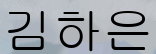

ID: 1
Bounding Box: (450, 252, 877, 309)
PaddleOCR: 900524-6116552
TesseractOCR: 900524-6116552
Final Text: 900524-6116552


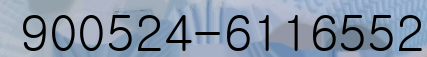

ID: 2
Bounding Box: (459, 670, 671, 717)
PaddleOCR: 86673333
TesseractOCR: 3667 .33.33.
Final Text: 3667 .33.33.


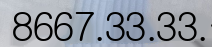

ID: 3
Bounding Box: (68, 32, 228, 78)
PaddleOCR: 1종보통
TesseractOCR: 1종 보통
Final Text: 1종보통


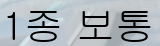

ID: 4
Bounding Box: (751, 506, 1020, 552)
PaddleOCR: ~ 72661700
TesseractOCR: ~ /266.17.00.
Final Text: ~ /266.17.00.


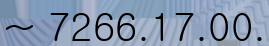

ID: 5
Bounding Box: (657, 663, 1040, 719)
PaddleOCR: 경상북도경찰청장
TesseractOCR: 경상북도경찰청장/
Final Text: 경상북도경찰청장


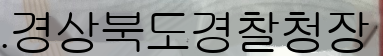

ID: 6
Bounding Box: (443, 113, 1037, 183)
PaddleOCR: 96-42-384655-1!
TesseractOCR: 96-42-384655-1!
Final Text: 96-42-384655-1!


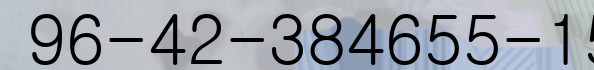

ID: 7
Bounding Box: (1036, 549, 1169, 590)
PaddleOCR: S3264X
TesseractOCR: S3264X
Final Text: S3264X


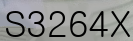

ID: 8
Bounding Box: (463, 311, 844, 410)
PaddleOCR: 토산레열시출미문공
TesseractOCR: 부산광역시 동대문구
& AHH 23522) 1236
Final Text: 부산광역시 동대문구
& AHH 23522) 1236


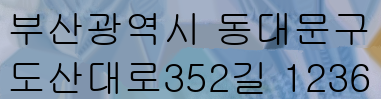

ID: 9
Bounding Box: (728, 464, 958, 507)
PaddleOCR: 66765800
TesseractOCR: 6676.58.00.
Final Text: 6676.58.00.


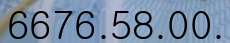

ID: 10
Bounding Box: (540, 59, 1102, 107)
PaddleOCR: 자동차운전면허증Oriver's License
TesseractOCR: MEAS A FA Of = (Driver's License)
Final Text: 자동차운전면허증Oriver's License


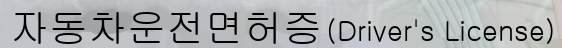

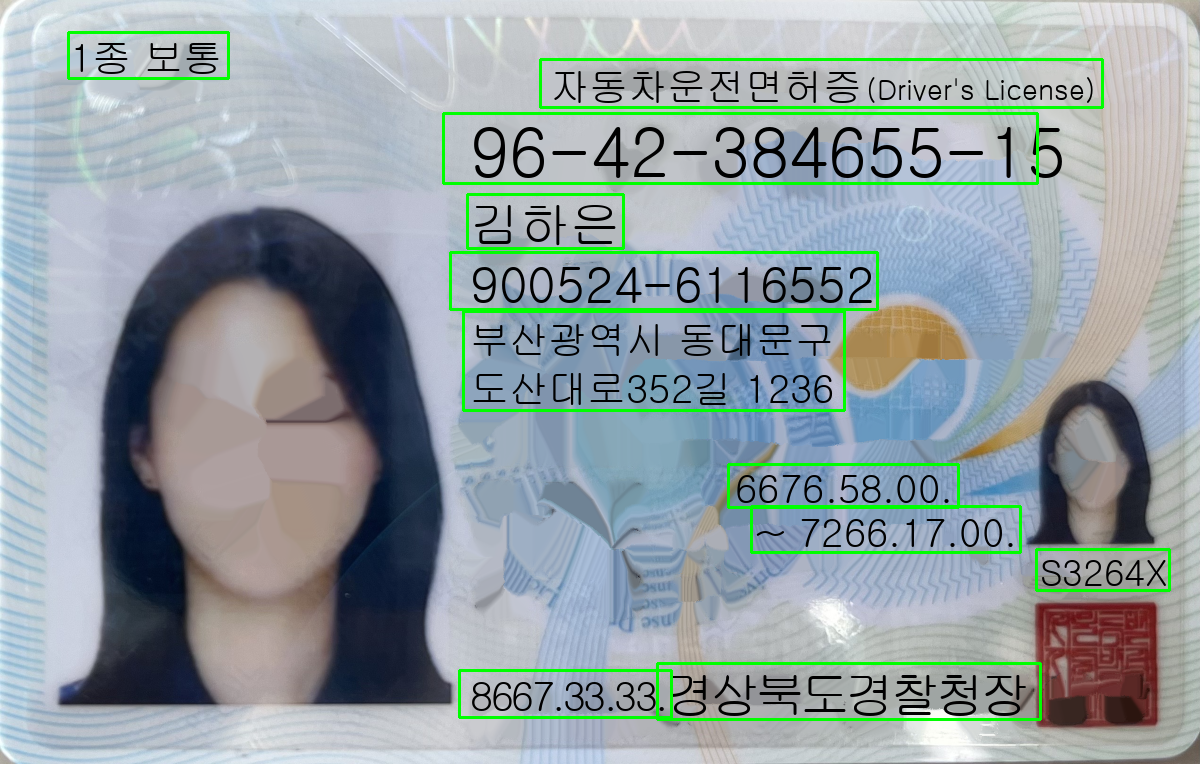

[{'id': 1, 'feedback': '주민등록번호로 의심됩니다.'}, {'id': 6, 'feedback': '면허번호로 의심됩니다.'}, {'id': 8, 'feedback': '여권 기계판독영역으로 의심됩니다.'}]


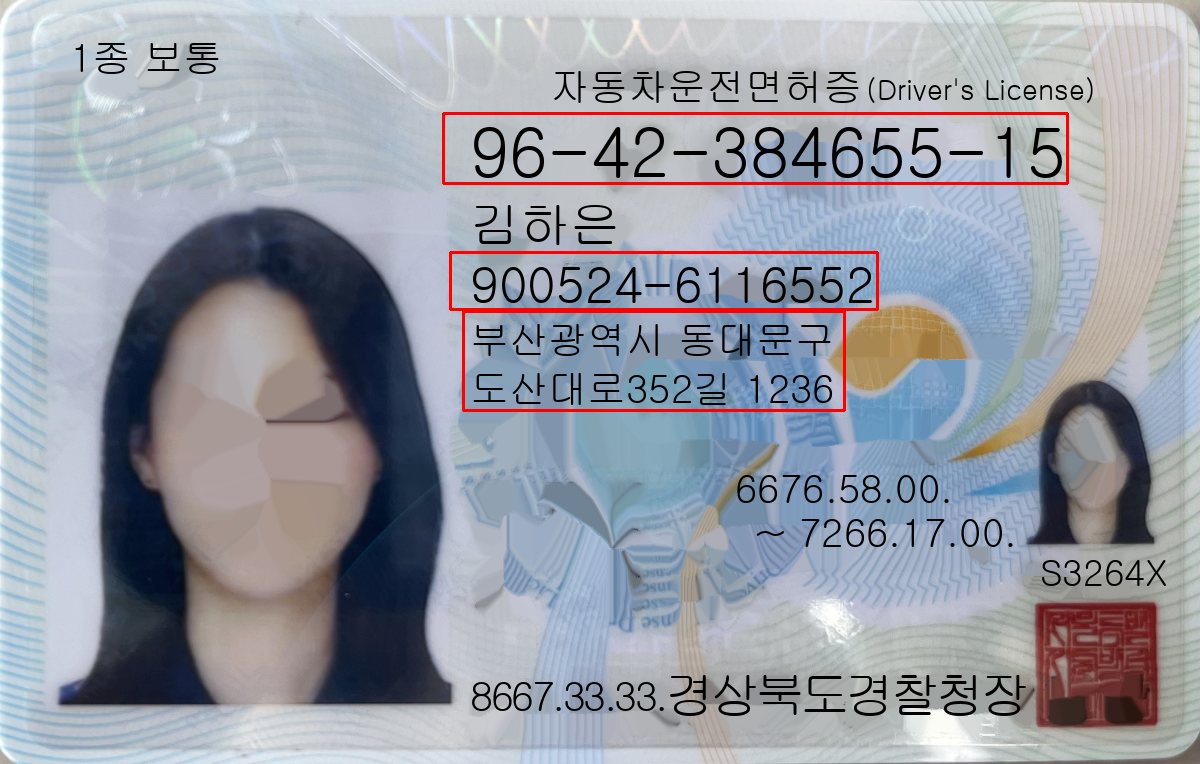

In [ ]:
# 실행 예제
if __name__ == "__main__":
    # 테스트 실행
    tfidf_vectorizer = joblib.load("/content/drive/MyDrive/예비캡스톤/XGBoost/tfidf_vectorizer.pkl")
    yolo_model_path = '/content/drive/MyDrive/yolov5_training_results/epochs_60/weights/best.pt'  # YOLO 모델 경로
    image_path = '/content/drive/MyDrive/예비캡스톤/fake_license_image/license_image/fake_license_sample_40.png'  # 테스트 이미지 경로

    feedback, image_path, fb_img, updated_text_regions = process_image(image_path)

    print(feedback)
    cv2_imshow(fb_img)

In [ ]:
# 최종 통합
def final(model_path, image_path):
    # YOLO 모델 로드
    model = load_yolo_model(model_path)

    # 이미지에서 텍스트 영역 탐지
    image, text_regions = detect_text_regions(model, image_path)

    # OCR 모델 초기화
    ocr_model = PaddleOCR(use_angle_cls=True, lang='korean', use_space_char=True, rec_algorithm='CRNN')

    # OCR 수행 (Paddle + Tesseract 통합)
    ocr_results = perform_combined_ocr(image, text_regions, ocr_model)

    # XGBoost로 레이블 분류
    classifications = classify_with_xgboost(ocr_results)

    # 개인정보 여부 판단
    is_personal = determine_personal_info(classifications)

    # 피드백 생성
    feedback = generate_feedback(is_personal)

    # 특정 레이블 5에 대해 x2 좌표 확장
    fb_img, updated_text_regions = draw_bounding_boxes_with_extension(
        image_path, text_regions, classifications, feedback, label_to_extend=5, extension=30
    )

    # 결과 반환
    return feedback, image_path, fb_img, updated_text_regions

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-12-19 Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


YOLOv5 모델이 성공적으로 로드되었습니다: /content/drive/MyDrive/yolov5_training_results/epochs_60/weights/best.pt
[2024/12/19 08:00:33] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ml/Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='CRNN', rec_model_dir='/root/.paddleocr/whl/rec/korean/korean_PP-OCR

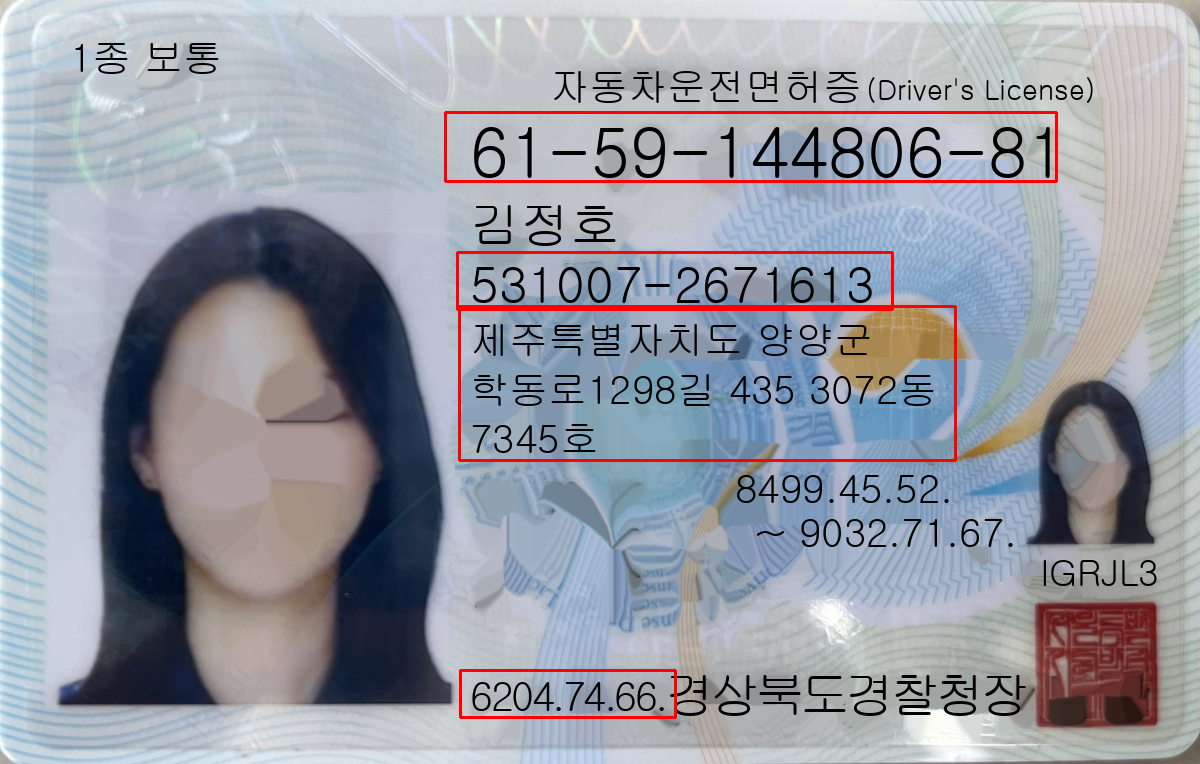

In [ ]:
# 실행
if __name__ == "__main__":
    tfidf_vectorizer = joblib.load("/content/drive/MyDrive/예비캡스톤/XGBoost/tfidf_vectorizer.pkl")
    yolo_model_path = '/content/drive/MyDrive/yolov5_training_results/epochs_60/weights/best.pt'  # YOLO 모델 경로
    image_path = '/content/drive/MyDrive/예비캡스톤/fake_license_image/license_image/fake_license_sample_1079.png'  # 테스트 이미지 경로

    feedback, image_path, fb_img, updated_text_regions = final(yolo_model_path, image_path)

    print(feedback)
    cv2_imshow(fb_img)

In [ ]:
def blur_bounding_boxes(image_path, text_regions, selected_ids):
    """
    원본 이미지에서 선택된 여러 ID의 바운딩 박스를 블러 처리하는 함수

    Args:
        image_path (str): 이미지 경로
        text_regions (list): 바운딩 박스 정보 [{"id": int, "bbox": (x1, y1, x2, y2)}]
        selected_ids (list): 선택된 바운딩 박스 ID 리스트

    Returns:
        numpy array: 블러 처리된 이미지
    """
    # 이미지 읽기
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

    # 이미지 복사본 생성
    output_image = image.copy()

    # 선택된 ID에 해당하는 바운딩 박스 모두 블러 처리
    for region in text_regions:
        if region["id"] in selected_ids:  # ID가 선택된 ID 리스트에 포함되어 있는지 확인
            x1, y1, x2, y2 = region["bbox"]
            # ROI(관심 영역) 추출
            roi = output_image[y1:y2, x1:x2]
            # Gaussian Blur 적용
            blurred_roi = cv2.GaussianBlur(roi, (101, 101), 0)
            # 블러 처리된 영역을 원본 이미지에 적용
            output_image[y1:y2, x1:x2] = blurred_roi

    return output_image

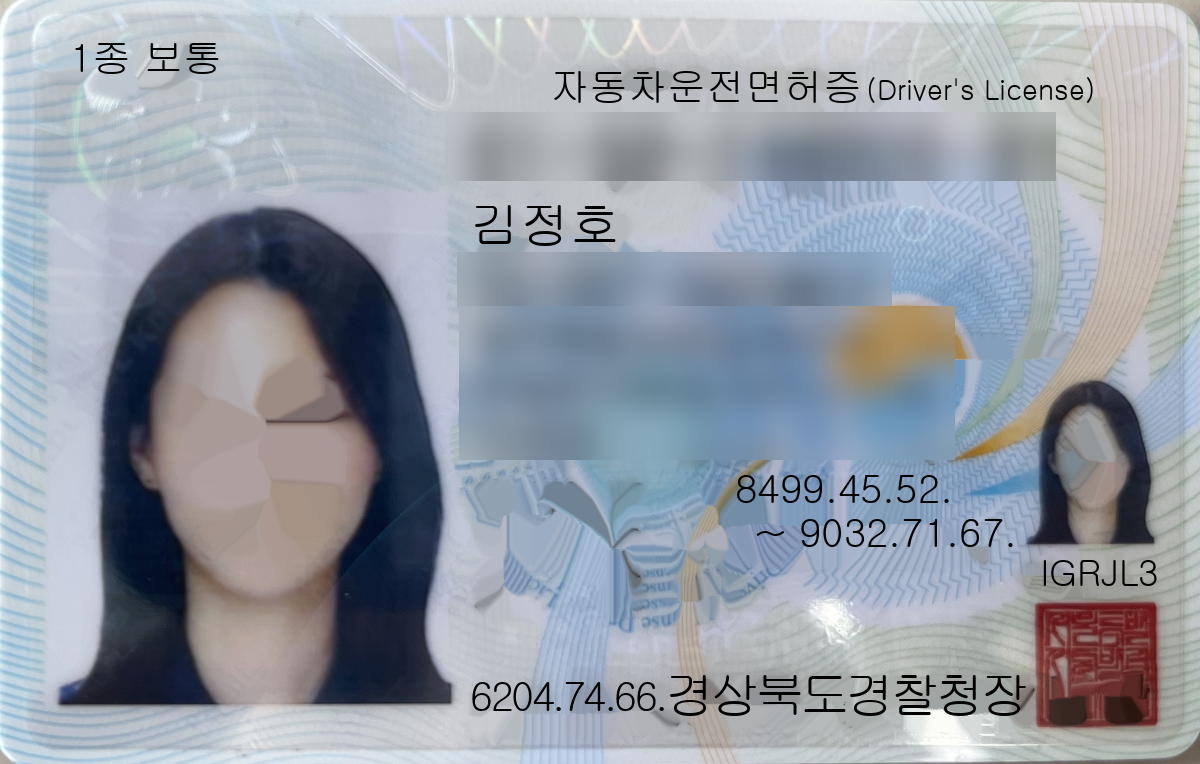

In [ ]:
selected_ids = [1, 3, 9]     # 서버로부터 받아와야 함(updated_text_regions, selected_ids)

# 선택된 바운딩 박스 블러 처리
blurred_image = blur_bounding_boxes(image_path, updated_text_regions, selected_ids)

# 결과 이미지 시각화
cv2_imshow(blurred_image)